[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)

#### based on Fig. 3 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol_code import AerosolMarine, AerosolBoreal

from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
import os
from joblib import Parallel, delayed, parallel_backend

In [3]:
CI = 'CI' in os.environ

nRes = 4
updraft_list = np.geomspace(0.1, 10, 2 if CI else nRes)
forg_list = np.linspace(0.05, 0.95, 2 if CI else nRes)

subplot_list = ["a","b","c","d"]
models = ('Constant', 'CompressedFilmOvadnevaite')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

consts = {"delta_min":0.1, 
          "MAC":1, 
          "HAC":1, 
          "c_pd":1006 * si.joule / si.kilogram / si.kelvin, 
          "g_std":9.81 * si.metre / si.second ** 2,
          "scipy_ode_solver":False
          }

In [4]:
def compute(key, settings):
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.modes[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(forg_list) * len(updraft_list)}')
print(updraft_list)
with parallel_backend('loky', n_jobs=-1):
    output = dict(Parallel(verbose=10)(
        delayed(compute)(subplot+f"_w{w:.2f}_f{Forg:.2f}_"+model, Settings(
            dz = 10 * si.m if CI else 1 * si.m,
            n_sd_per_mode = 10 if CI else 50,
            model = model,
            aerosol = {
                "a": AerosolMarine(Forg=Forg, Acc_N2=Acc["a"]),
                "b": AerosolMarine(Forg=Forg, Acc_N2=Acc["b"]),
                "c": AerosolBoreal(Forg=Forg, Acc_N2=Acc["c"]),
                "d": AerosolBoreal(Forg=Forg, Acc_N2=Acc["d"])
            }[subplot],
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
            **consts
        ))
        for w in updraft_list
        for Forg in forg_list
        for subplot in subplot_list
        for model in models
    ))

tasks scheduled: 128
[ 0.1         0.46415888  2.15443469 10.        ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 10.0min finished


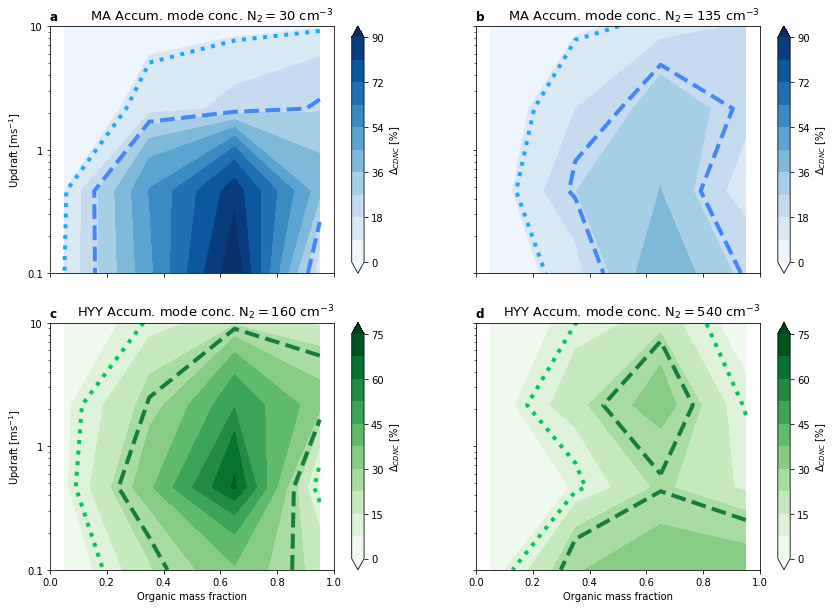

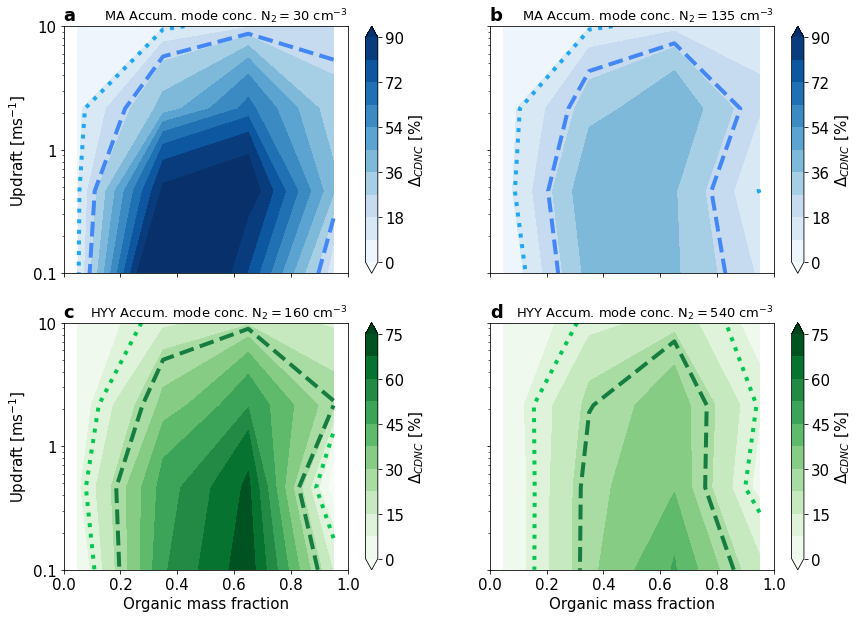

In [5]:
from PySDM_examples.Lowe_et_al_2019.plot_helper import plot_contours
plot_contours(subplot_list, updraft_list, forg_list, output, actfrac=False, save=False)
plot_contours(subplot_list, updraft_list, forg_list, output, actfrac=True, save=False)

# from PySDM_examples.Lowe_et_al_2019.plot_helper import plot_profiles
# plot_profiles(subplot_list, updraft_list, forg_list, output, save=False)

In [6]:
# for k, subplot in enumerate(subplot_list):
#     print(subplot, ", bulk")
#     for i, w in enumerate(updraft_list):
#         for j, Forg in enumerate(forg_list):
#             key = subplot + f"_w{w:.2f}_f{Forg:.2f}_"
#             var = "n_c_cm3"
#             z = np.array(output[key + "CompressedFilmOvadnevaite"]["z"])
#             CDNC_bulk = np.array(output[key + "Constant"][var])
#             print(f"{w:.2e}, {Forg:.2f}, {CDNC_bulk[-1]:.2f}")
        
# for k, subplot in enumerate(subplot_list):
#     print(subplot, ", film")
#     for i, w in enumerate(updraft_list):
#         for j, Forg in enumerate(forg_list):
#             key = subplot + f"_w{w:.2f}_f{Forg:.2f}_"
#             var = "n_c_cm3"
#             z = np.array(output[key + "CompressedFilmOvadnevaite"]["z"])
#             CDNC_film = np.array(output[key + "CompressedFilmOvadnevaite"][var])
#             print(f"{w:.2e}, {Forg:.2f}, {CDNC_film[-1]:.2f}")